In [2]:
import numpy
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from doodleLoaderSimple import DoodleDatasetSimple
from matplotlib import pyplot as plt

## Training and validation for the house image classifier

In [3]:
# Number to class labels mapping
class_dict = {
    0: 'stress',
    1: 'introvert',
    2: 'extrovert'
}

# Loading the data from the .csv file
# First row is a header
data = np.genfromtxt(r'D:\COLLEGE_STUDIES\SEM-6\ML_NLP_project\data\houseData.csv', dtype=int, delimiter=',', names=True)

print(data[:5]) 

[(0, 0) (1, 1) (2, 2) (3, 0) (4, 1)]


In [4]:
# # Visualization: Plot the distribution of classes
# def plot_class_distribution(translation_dict):
#     """
#     Plots the distribution of class labels in the dataset.
    
#     :param translation_dict: Dictionary mapping image filenames to class labels.
#     """
#     class_counts = np.bincount(list(translation_dict.values()))  # Count occurrences of each class
#     class_labels = [class_dict[i] for i in range(len(class_counts))]  # Get class names
    
#     plt.figure(figsize=(4, 3))
#     plt.bar(class_labels, class_counts, color=['red', 'blue', 'green'])
#     plt.xlabel("Class Labels")
#     plt.ylabel("Number of Images")
#     plt.title("Class Distribution in Dataset")
#     plt.show()

# # Call the function to visualize the dataset distribution
# plot_class_distribution(translation_dict)

In [5]:
def count_classes(dictClass, arr):
    """
    Redundant method that counts the occurrences of each class in the dataset
    Can be used to create weights if the class distribution is unbalanced
    :param dictClass: Dictionary that maps number to class labels
    :param arr: The array that contains the data
    :return: The number of occurrences for each class in the given array
    """
    unique, count = numpy.unique(arr, return_counts=True)
    print(dict(zip(dictClass.values(), count)))
    count = 1 / count
    count = count / sum(count)
    return count

In [6]:
# Match the image IDs to the ID values in the .csv file.
translation_dict = dict( zip([f'{id}.png' for id in data['id']], data['class']))

# Prepare each image to be passed as a Tensor product to the model.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Prepare the data by matching it to its label and transforming it to a Tensor product.
housedata = DoodleDatasetSimple(r'D:\\COLLEGE_STUDIES\\SEM-6\\ML_NLP_project\\images\\house\\', data_transforms, translation_dict)


In [7]:
# 80% of the data for training.
train_len = int(housedata.__len__() * 0.8)
# 20% of the data for validation.
test_len = int(housedata.__len__() * 0.2 + 1)
# Split the data at a random point.
train_set, val_set = torch.utils.data.random_split(housedata, [train_len, test_len])
# Shuffle and load the labeled images in batches of 4 for training.
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
# Load the labeled images in batches of 4 for validation after training the model.
test_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=0, drop_last=True)


## Model Definition

In [8]:
class MultilabelClassifier(nn.Module):
    def __init__(self, n_features):
        super(MultilabelClassifier, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, n_features)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  # Output tensor directly (not dictionary)

In [9]:
# Set the device to use as the GPU if there is compatible hardware
# Otherwise run the model on the cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultilabelClassifier(3).to(device)


In [10]:
def criterion(outputs, pictures):
    loss_func = nn.CrossEntropyLoss()
    labelsTensor = pictures['class'].to(device).long()  # Ensure label is `long` for CrossEntropyLoss
    return loss_func(outputs, labelsTensor)


In [11]:
def training(model, device, lr_rate, epochs, train_loader):
    """
    Method used by the model for training
    :param model: The model to train
    :param device: Which device to use for computation, GPU or CPU
    :param lr_rate: The learning rate used by the optimizing function
    :param epochs: How many epochs to train the model for
    :param train_loader: The loader that provides the labeled images in batches
    :return: An array containing the losses after each epoch
    """
    num_epochs = epochs
    losses = []
    checkpoint_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    n_total_steps = len(train_loader)

    for epoch in range(num_epochs):
        for i, pictures in enumerate(train_loader):
            images = pictures['image'].to(device)

            output = model(images)

            loss = criterion(output, pictures)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % (int(n_total_steps / 1)) == 0:
                checkpoint_loss = torch.tensor(losses).mean().item()
                checkpoint_losses.append(checkpoint_loss)
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {checkpoint_loss:.4f}')

    # Snippet used to save the models for inferring during runtime.
    model_save_path = r'D:\COLLEGE_STUDIES\SEM-6\ML_NLP_project\model\house\house_model_12.tar'
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': checkpoint_losses,
    }, model_save_path)



    return checkpoint_losses


In [12]:
# Call the method to train the model
checkpoint_losses = training(model, device, 0.0001, 70, train_loader)


Epoch [1/70], Step [107/107], Loss: 0.8364
Epoch [2/70], Step [107/107], Loss: 0.7903
Epoch [3/70], Step [107/107], Loss: 0.7611
Epoch [4/70], Step [107/107], Loss: 0.7266
Epoch [5/70], Step [107/107], Loss: 0.7003
Epoch [6/70], Step [107/107], Loss: 0.6833
Epoch [7/70], Step [107/107], Loss: 0.6612
Epoch [8/70], Step [107/107], Loss: 0.6451
Epoch [9/70], Step [107/107], Loss: 0.6309
Epoch [10/70], Step [107/107], Loss: 0.6097
Epoch [11/70], Step [107/107], Loss: 0.5904
Epoch [12/70], Step [107/107], Loss: 0.5812
Epoch [13/70], Step [107/107], Loss: 0.5683
Epoch [14/70], Step [107/107], Loss: 0.5521
Epoch [15/70], Step [107/107], Loss: 0.5375
Epoch [16/70], Step [107/107], Loss: 0.5243
Epoch [17/70], Step [107/107], Loss: 0.5116
Epoch [18/70], Step [107/107], Loss: 0.4985
Epoch [19/70], Step [107/107], Loss: 0.4876
Epoch [20/70], Step [107/107], Loss: 0.4751
Epoch [21/70], Step [107/107], Loss: 0.4629
Epoch [22/70], Step [107/107], Loss: 0.4510
Epoch [23/70], Step [107/107], Loss: 0.44

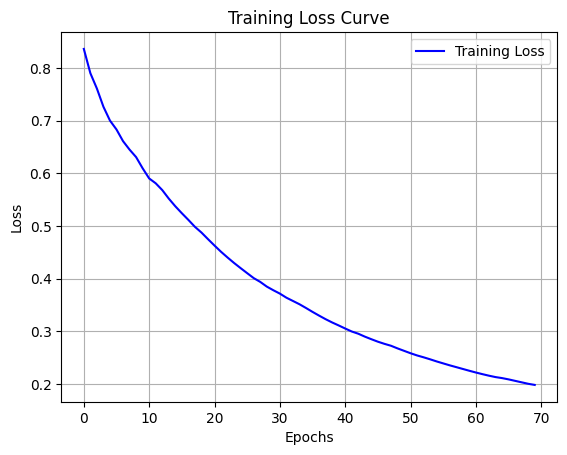

In [13]:
plt.plot(checkpoint_losses, linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import torch

def validation(model, dataloader, device):
    """
    Validates the model after training.

    :param model: The trained model.
    :param dataloader: Dataloader providing labeled images in batches.
    :param device: Device (CPU or GPU) for computation.
    :return: Model accuracy in percentage.
    """
    model.eval()  # Set model to evaluation mode
    n_correct = 0
    n_samples = 0

    with torch.no_grad():  # Disable gradient calculations for efficiency
        for pictures in dataloader:
            images, labels = pictures['image'].to(device), pictures['class'].to(device)

            outputs = model(images)  # Directly get model output
            _, predicted = torch.max(outputs, 1)  # Get highest probability class

            n_correct += (predicted == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100.0 * n_correct / n_samples if n_samples > 0 else 0.0  # Avoid division by zero
    print(f"Validation Accuracy: {acc:.2f}%")

    return acc



In [15]:
# Ensure model is on correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run validation
accuracy = validation(model, test_loader, device)


Validation Accuracy: 91.67%
